# Validate Logistic Loss Equations

*This notebook uses finite differences to validate the logistic loss equations.*

## Import Dependencies

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt
import scipy
from scipy.special import expit

## Set Parameters

In [2]:
delta = 1.0e-3
alphas = np.arange(0.25, 2.5, 0.125)
X, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X)
X = np.hstack((X, np.ones((X.shape[0], 1))))
y = 2*y - 1

## Define Functions

### loss

In [3]:
def loss(y, u):
    return np.log(1 + np.exp(-y*u))

In [4]:
def loss1(y, u):
    return -y / (1 + np.exp(y * u))

In [5]:
def loss2(y, u):
    p = 1 / (1 + np.exp(-u))
    q = 1 - p
    return q * p

In [6]:
def loss3(y, u):
    p = 1 / (1 + np.exp(-u))
    q = 1 - p
    return q * p * (q - p)

In [7]:
def loss4(y, u):
    p = 1 / (1 + np.exp(-u))
    q = 1 - p
    return q * p * (q**2 + p**2) - 4 * q**2 * p**2

### u_tilde

In [8]:
def u_tilde(y, u, h):
    return u + loss1(y, u) * h / (1 - loss2(y, u)*h)

In [9]:
def u_tilde_du(y, u, h):
    term1 = 1 / (1 - loss2(y, u)*h)
    term2 = loss1(y, u) * loss3(y, u)*h**2/(1 - loss2(y, u)*h)**2
    return term1 + term2

In [10]:
def u_tilde_dh(y, u, h):
    return loss1(y, u) / (1 - loss2(y, u)*h)**2

In [11]:
def u_tilde_du2(y, u, h):
    term1 = loss3(y, u)*h / (1 - loss2(y, u)*h)**2
    
    term2 = (loss2(y, u)*loss3(y, u) + loss1(y, u)*loss4(y, u))*h**2
    term2 /= (1 - loss2(y, u)*h)**2
    
    term3 = 2 * loss1(y, u) * loss3(y, u)**2 * h**3
    term3 /= (1 - loss2(y, u)*h)**3
    
    return term1 + term2 + term3

In [12]:
def u_tilde_du_dh(y, u, h):
    term1 = loss2(y, u) / (1 - loss2(y, u)*h)**2
    term2 = 2 * loss1(y, u)*loss3(y, u)*h / (1 - loss2(y, u)*h)**3
    return term1 + term2

In [13]:
def u_tilde_dh2(y, u, h):
    return 2 * loss1(y, u)*loss2(y, u) / (1 - loss2(y, u)*h)**3

### l_tillde

In [14]:
def l_tilde(y, u, h):
    return loss(y, u_tilde(y, u, h))

In [15]:
def l_tilde_du(y, u, h):
    return loss1(y, u_tilde(y, u, h)) * u_tilde_du(y, u, h)

In [16]:
def l_tilde_dh(y, u, h):
    return loss1(y, u_tilde(y, u, h)) * u_tilde_dh(y, u, h)

In [17]:
def l_tilde_du2(y, u, h):
    t = u_tilde(y, u, h)
    term1 = loss1(y, t) * u_tilde_du2(y, u, h)
    term2 = loss2(y, t) * u_tilde_du(y, u, h)**2
    return term1 + term2

In [18]:
def l_tilde_du_dh(y, u, h):
    t = u_tilde(y, u, h)
    term1 = loss1(y, t) * u_tilde_du_dh(y, u, h)
    term2 = loss2(y, t) * u_tilde_du(y, u, h) * u_tilde_dh(y, u, h)
    return term1 + term2

In [19]:
def l_tilde_dh2(y, u, h):
    t = u_tilde(y, u, h)
    term1 = loss1(y, t) * u_tilde_dh2(y, u, h)
    term2 = loss2(y, t) * u_tilde_dh(y, u, h)**2
    return term1 + term2

## ALO

In [20]:
def fit_logistic_regression(X, y, alpha):
    C = 1 / (2*alpha**2)
    model = LogisticRegression(solver='lbfgs', C=C, fit_intercept=False)
    model.fit(X, y)
    return np.array(list(model.coef_[0]))

In [21]:
def compute_hessian(X, y, u, alpha):
    n, k = X.shape
    a = np.array([loss2(yi, ui) for yi, ui in zip(y, u)])
    H = np.dot(X.T, a.reshape((n, 1))*X)
    for i in range(k):
        H[i, i] += 2*alpha**2
    return H

In [22]:
def compute_h(X, L):
    T = scipy.linalg.solve_triangular(L, X.T, lower=True)
    result = np.array([np.dot(ti, ti) for ti in T.T])
    return result

In [23]:
def compute_alo(X, y, alpha):
    beta_hat = fit_logistic_regression(X, y, alpha)
    u_vector = np.dot(X, beta_hat)
    H = compute_hessian(X, y, u_vector, alpha)
    L = np.linalg.cholesky(H)
    h = compute_h(X, L)
    result = 0
    for yi, ui, hi in zip(y, u_vector, h):
        result += l_tilde(yi, ui, hi)
    return result

### Derivative

In [24]:
def compute_beta_hat_derivative(L, alpha, beta_hat):
    result = scipy.linalg.solve_triangular(L, beta_hat, lower=True)
    result = scipy.linalg.solve_triangular(L.T, result, lower=False)
    return -4 * alpha * result

In [25]:
def compute_hessian_derivative(X, y, u, u_d, alpha):
    n, k = X.shape
    a_d = np.array([loss3(yi, ui) * u_di for yi, ui, u_di in zip(y, u, u_d)])
    result = np.dot(X.T, a_d.reshape((n, 1))*X)
    for i in range(k):
        result[i, i] += 4*alpha
    return result

In [26]:
def compute_h_derivative(X, y, L, u, u_d, alpha):
    H_d = compute_hessian_derivative(X, y, u, u_d, alpha)
    T = scipy.linalg.solve_triangular(L, X.T, lower=True)
    T = scipy.linalg.solve_triangular(L.T, T, lower=False)
    R = np.dot(H_d, T)
    result = [-np.dot(ti, ri) for ti, ri in zip(T.T, R.T)]
    return np.array(result)

In [27]:
def compute_alo_derivative(X, y, alpha):
    beta_hat = fit_logistic_regression(X, y, alpha)   
    u = np.dot(X, beta_hat)
    H = compute_hessian(X, y, u, alpha)
    L = np.linalg.cholesky(H)
    beta_hat_d = compute_beta_hat_derivative(L, alpha, beta_hat)
    u_d = np.dot(X, beta_hat_d)
    h = compute_h(X, L)
    h_d = compute_h_derivative(X, y, L, u, u_d, alpha)
    result = 0
    for yi, ui, u_di, hi, h_di in zip(y, u, u_d, h, h_d):
        result += l_tilde_du(yi, ui, hi) * u_di + l_tilde_dh(yi, ui, hi) * h_di
    return result

### Second Derivative

In [28]:
def compute_beta_hat_derivative2(X, y, L, u, u_d, beta_hat, 
                                 beta_hat_d, alpha):
    result = [loss3(yi, ui) * u_di**2 for yi, ui, u_di in zip(y, u, u_d)]
    result = np.dot(X.T, result)
    result += 8 * alpha * beta_hat_d
    result += 4 * beta_hat
    result = scipy.linalg.solve_triangular(L, result, lower=True)
    return -scipy.linalg.solve_triangular(L.T, result, lower=False)

In [29]:
def compute_hessian_derivative2(X, y, u, u_d, u_d2):
    n, k = X.shape
    a_d2 = np.array([loss3(yi, ui)*u_d2i + loss4(yi, ui) * u_di**2 \
               for yi, ui, u_di, u_d2i in zip(y, u, u_d, u_d2)])
    result = np.dot(X.T, a_d2.reshape((n, 1))*X)
    for i in range(k):
        result[i, i] += 4
    return result

In [30]:
def compute_h_derivative2(X, y, L, u, u_d, u_d2, alpha):
    H_d = compute_hessian_derivative(X, y, u, u_d, alpha)
    H_d2 = compute_hessian_derivative2(X, y, u, u_d, u_d2)
    T = scipy.linalg.solve_triangular(L, X.T, lower=True)
    T = scipy.linalg.solve_triangular(L.T, T, lower=False)
    R = np.dot(H_d, T)
    R = scipy.linalg.solve_triangular(L, R, lower=True)
    Q = np.dot(H_d2, T)
    result = [2*np.dot(ri, ri) - np.dot(ti, qi) \
                 for ri, ti, qi in zip(R.T, T.T, Q.T)]
    return np.array(result)

In [31]:
def compute_alo_derivative2(X, y, alpha):
    beta_hat = fit_logistic_regression(X, y, alpha)   
    u = np.dot(X, beta_hat)
    H = compute_hessian(X, y, u, alpha)
    L = np.linalg.cholesky(H)
    beta_hat_d = compute_beta_hat_derivative(L, alpha, beta_hat)
    u_d = np.dot(X, beta_hat_d)
    h = compute_h(X, L)
    h_d = compute_h_derivative(X, y, L, u, u_d, alpha)
    beta_hat_d2 = compute_beta_hat_derivative2(
        X, y, L, u, u_d, beta_hat, beta_hat_d, alpha)
    u_d2 = np.dot(X, beta_hat_d2)
    h_d2 = compute_h_derivative2(X, y, L, u, u_d, u_d2, alpha)
    result = 0
    for yi, ui, u_di, u_d2i, hi, h_di, h_d2i in \
                        zip(y, u, u_d, u_d2, h, h_d, h_d2):
        result += l_tilde_du(yi, ui, hi) * u_d2i
        result += l_tilde_du2(yi, ui, hi) * u_di**2
        result += 2*l_tilde_du_dh(yi, ui, hi) * u_di * h_di
        result += l_tilde_dh(yi, ui, hi) * h_d2i
        result += l_tilde_dh2(yi, ui, hi) * h_di**2
    return result

## LO

In [32]:
def compute_lo(X, y, alpha):
    C = 1 / (2*alpha**2)
    model = LogisticRegression(solver='lbfgs', C=C, fit_intercept=False)
    result = 0
    values = sorted(list(set(y)))
    for train_indexes, test_indexes in LeaveOneOut().split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        y_train = y[train_indexes]
        y_test = y[test_indexes]
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)[0]
        index = values.index(y_test[0])
        result += np.log(pred[index])
    return -result

## Validate

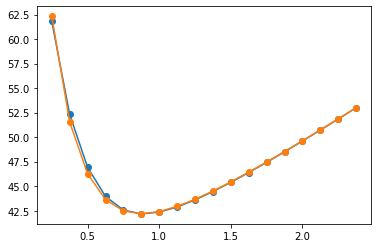

In [33]:
alos = [compute_alo(X, y, alpha) for alpha in alphas]
los = [compute_lo(X, y, alpha) for alpha in alphas]
plt.plot(alphas, alos, label='ALO', marker='o')
plt.plot(alphas, los, label='LO', marker='o')

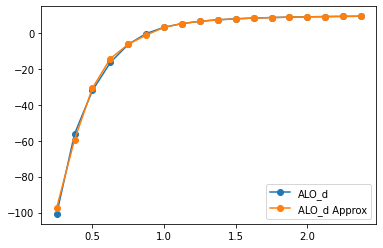

In [34]:
def d_approx(alpha):
    f1 = compute_alo(X, y, alpha + delta)
    f0 = compute_alo(X, y, alpha)
    return (f1 - f0) / delta
alo_ds_approx = [d_approx(alpha) for alpha in alphas]
alo_ds = [compute_alo_derivative(X, y, alpha) for alpha in alphas]
plt.plot(alphas, alo_ds, label='ALO_d', marker='o')
plt.plot(alphas, alo_ds_approx, label='ALO_d Approx', marker='o')
plt.legend()

In [ ]:
def d_approx(alpha):
    f1 = compute_alo_derivative(X, y, alpha + delta)
    f0 = compute_alo_derivative(X, y, alpha)
    return (f1 - f0) / delta
alo_ds_approx = [d_approx(alpha) for alpha in alphas]
alo_ds = [compute_alo_derivative2(X, y, alpha) for alpha in alphas]
plt.plot(alphas, alo_ds, label='ALO_d2', marker='o')
plt.plot(alphas, alo_ds_approx, label='ALO_d2 Approx', marker='o')
plt.legend()